# Project 4 - Image Warping and Mosaicing

### Dependencies

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils import compute_H, warp_image, warp_points, align_and_blend_images, get_harris_corners, adaptive_non_maximal_suppression, extract_feature_descriptors, visualize_descriptors, match_features, ransac

## Part A - Shoot and digitize pictures

In [2]:
img = plt.imread('../data/img/IMG_8427.jpeg')

with open('../data/points/ipad.json', 'r') as f:
    warped_points = json.load(f)

original_pts = np.array(warped_points["im1Points"])
new_pts = np.array(warped_points["im2Points"])

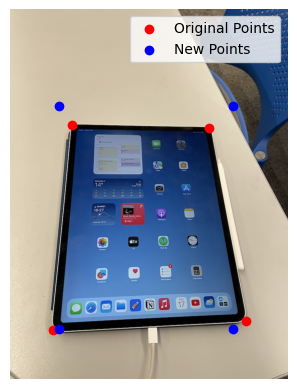

In [3]:
# Plot the image
fig, ax = plt.subplots()

# Plot the image
ax.imshow(img)

# Plot the points on the image
ax.scatter(original_pts[:, 0], original_pts[:, 1], c='r', label='Original Points')
ax.scatter(new_pts[:, 0], new_pts[:, 1], c='b', label='New Points')

ax.legend()
ax.axis('off')
plt.show()

## Part A - Recover homography

In [4]:
# Compute the homography matrix
H = compute_H(original_pts, new_pts)
print(H)

[[ 1.52333900e+00  2.64888668e-01 -1.72108177e+02]
 [-7.23715776e-02  2.21951598e+00 -3.60203781e+02]
 [-1.54841283e-04  9.33248462e-04  1.00000000e+00]]


## Part A - Warp the Images

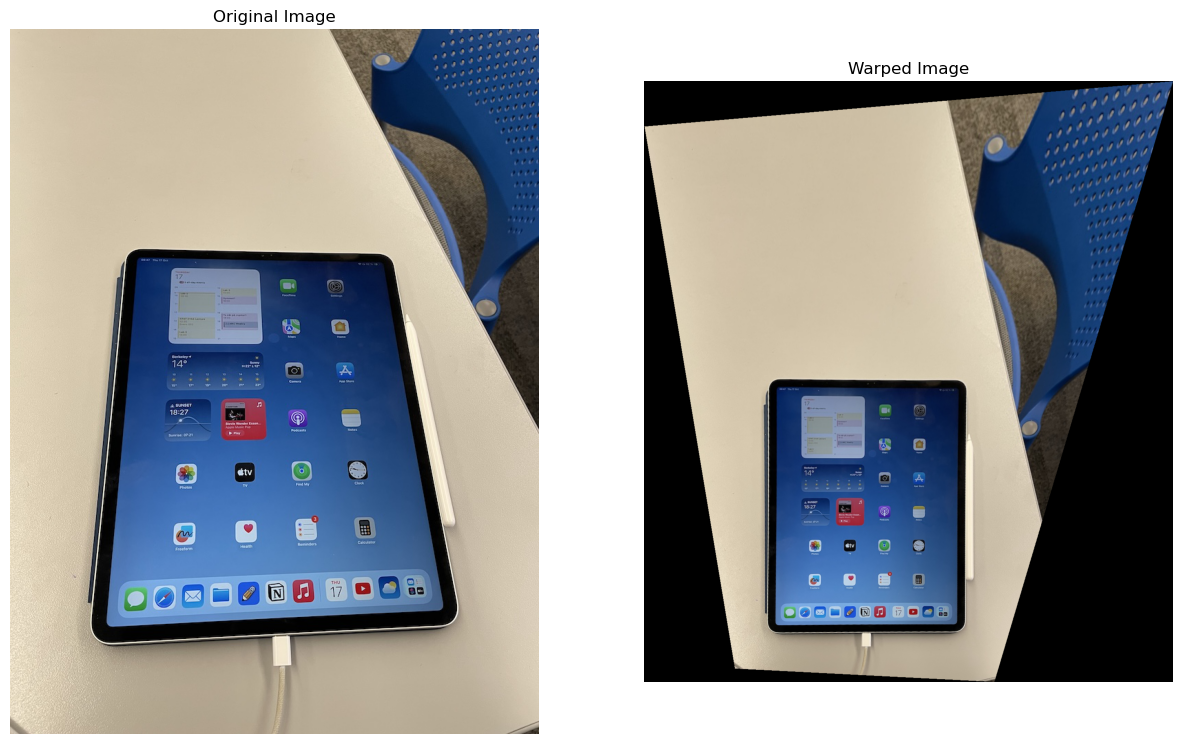

In [5]:
im_warped, _, _ = warp_image(img, H)

# Display the result
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Original image
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Warped image
ax[1].imshow(im_warped)
ax[1].set_title('Warped Image')
ax[1].axis('off')

plt.show()

## Part A - Blend the Images into Mosaics

In [6]:
# Load images and points
image_left = plt.imread('../data/img/IMG_8428.jpeg')
image_right = plt.imread('../data/img/IMG_8429.jpeg')

with open('../data/points/moffitt.json', 'r') as f:
    points = json.load(f)

image_left_pts = np.array(points["im1Points"])
image_right_pts = np.array(points["im2Points"])

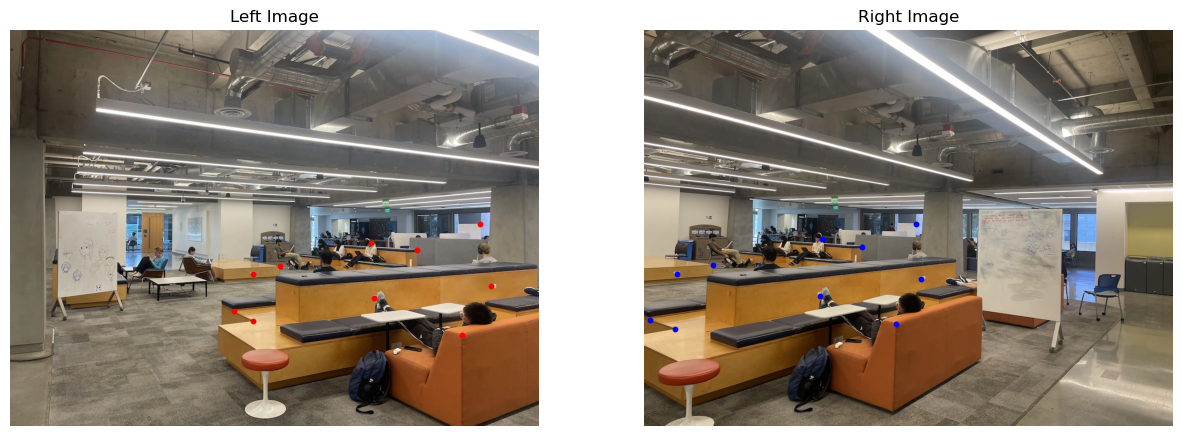

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Plot the left image
ax[0].imshow(image_left)
ax[0].scatter(image_left_pts[:, 0], image_left_pts[:, 1], c='r', s=10, label='Left Points')
ax[0].set_title('Left Image')
ax[0].axis('off')

# Plot the right image
ax[1].imshow(image_right)
ax[1].scatter(image_right_pts[:, 0], image_right_pts[:, 1], c='b', s=10, label='Right Points')
ax[1].set_title('Right Image')
ax[1].axis('off')

plt.show()

In [8]:
H = compute_H(image_left_pts, image_right_pts)

# Warp the right image to the left image's perspective
warped_left, min_x, min_y = warp_image(image_left, H)

# Warp the points from the right image to the left image's perspective
warped_points = warp_points(image_left_pts, H, min_x, min_y)

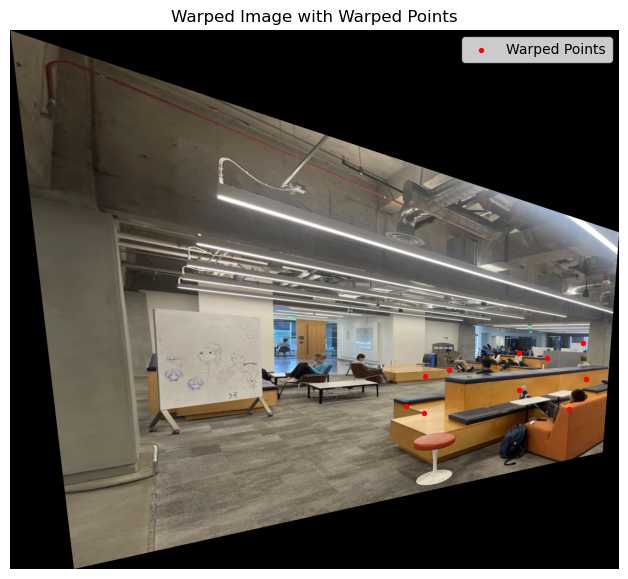

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

# Display the warped image
ax.imshow(warped_left)
ax.scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')

ax.legend()
ax.set_title('Warped Image with Warped Points')
ax.axis('off')

plt.show()

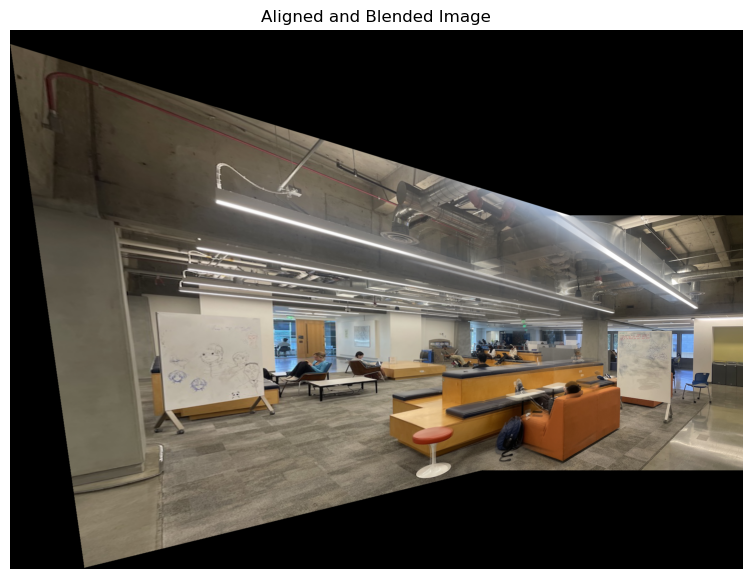

In [10]:
# Align and blend the images
manual_pts_result_img = align_and_blend_images(warped_left, image_right, warped_points, image_right_pts)

# Display the result
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(manual_pts_result_img)
ax.set_title('Aligned and Blended Image')
ax.axis('off')
plt.show()

## Part B - Interest Point Detector

In [11]:
# make images b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

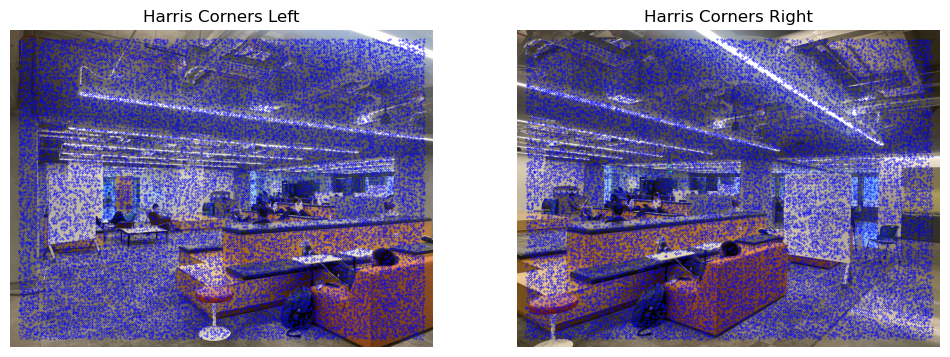

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Harris corners for the left image
ax[0].imshow(image_left)
ax[0].scatter(coords_left[1], coords_left[0], c='b', s=0.1)
ax[0].set_title('Harris Corners Left')
ax[0].axis('off')

# Display Harris corners for the right image
ax[1].imshow(image_right)
ax[1].scatter(coords_right[1], coords_right[0], c='b', s=0.1)
ax[1].set_title('Harris Corners Right')
ax[1].axis('off')

plt.show()

## Part B - Adaptive Non-Maximal Suppression

In [13]:
# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

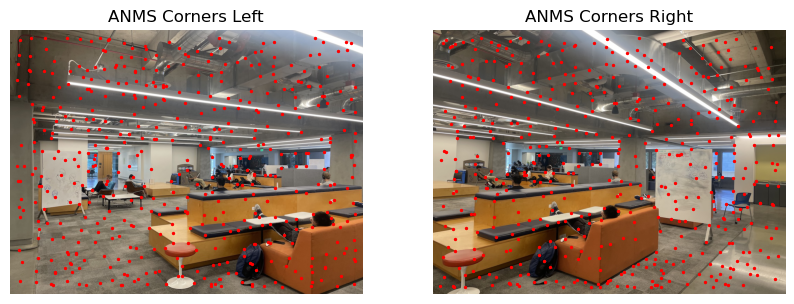

In [14]:
# Display ANMS corners
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Left image with ANMS corners
ax[0].imshow(image_left)
ax[0].scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
ax[0].set_title('ANMS Corners Left')
ax[0].axis('off')

# Right image with ANMS corners
ax[1].imshow(image_right)
ax[1].scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
ax[1].set_title('ANMS Corners Right')
ax[1].axis('off')

plt.show()

## Part B - Feature Descriptor Extraction

In [15]:
descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

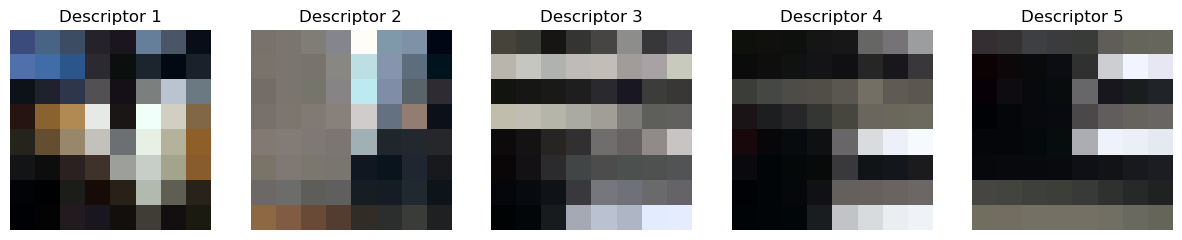

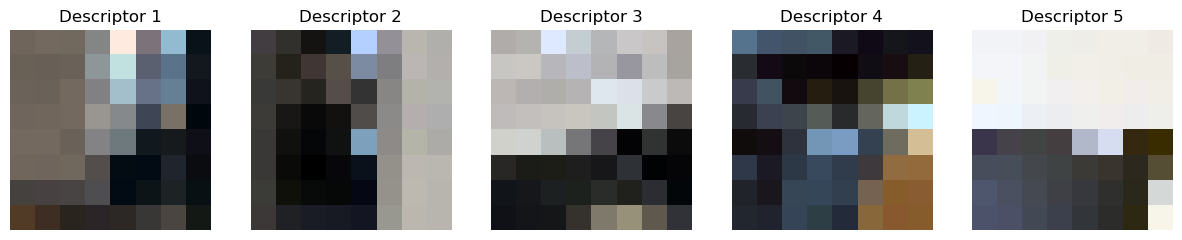

In [16]:
visualize_descriptors(descriptors_left, num_descriptors=5)
visualize_descriptors(descriptors_right, num_descriptors=5)

## Part B - Feature Matching

In [17]:
matches = match_features(descriptors_left, descriptors_right)

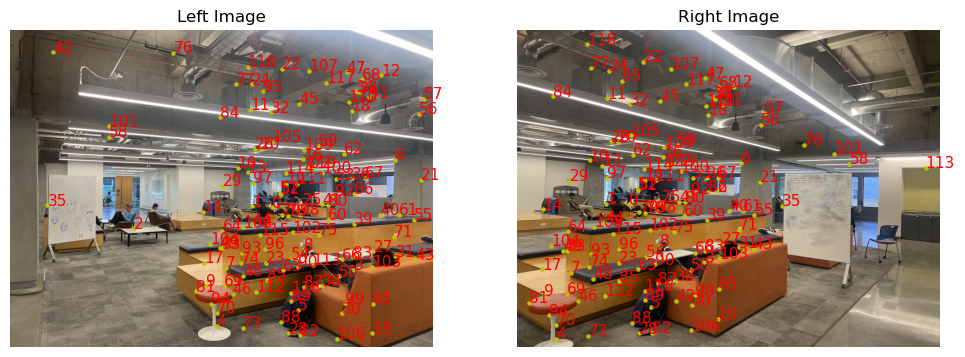

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')

ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    ax[0].axis('off')
    ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

## Part B - 4-Point RANSAC

In [19]:
final_H, best_inliers, best_im1_pts, best_im2_pts = ransac(suppressed_coords_left, suppressed_coords_right, matches)

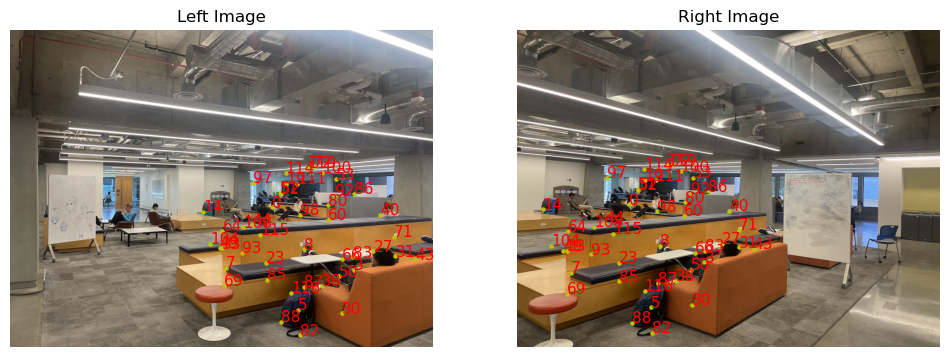

In [20]:
fix, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the left image
ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')

# Display the right image
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

# Loop through matches and process inliers
for idx, (i, j) in enumerate(matches):
    if idx in best_inliers:
        y1, x1 = suppressed_coords_left[:, i]
        y2, x2 = suppressed_coords_right[:, j]
        
        ax[0].axis('off')
        ax[0].scatter(x1, y1, c='y', s=5)
        ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
        
        ax[1].axis('off')
        ax[1].scatter(x2, y2, c='y', s=5)
        ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

In [21]:
# Warp the image
image_left_warped, min_x, min_y = warp_image(image_left, final_H)

# Warp the points
warped_points = warp_points(best_im1_pts, final_H, min_x, min_y)

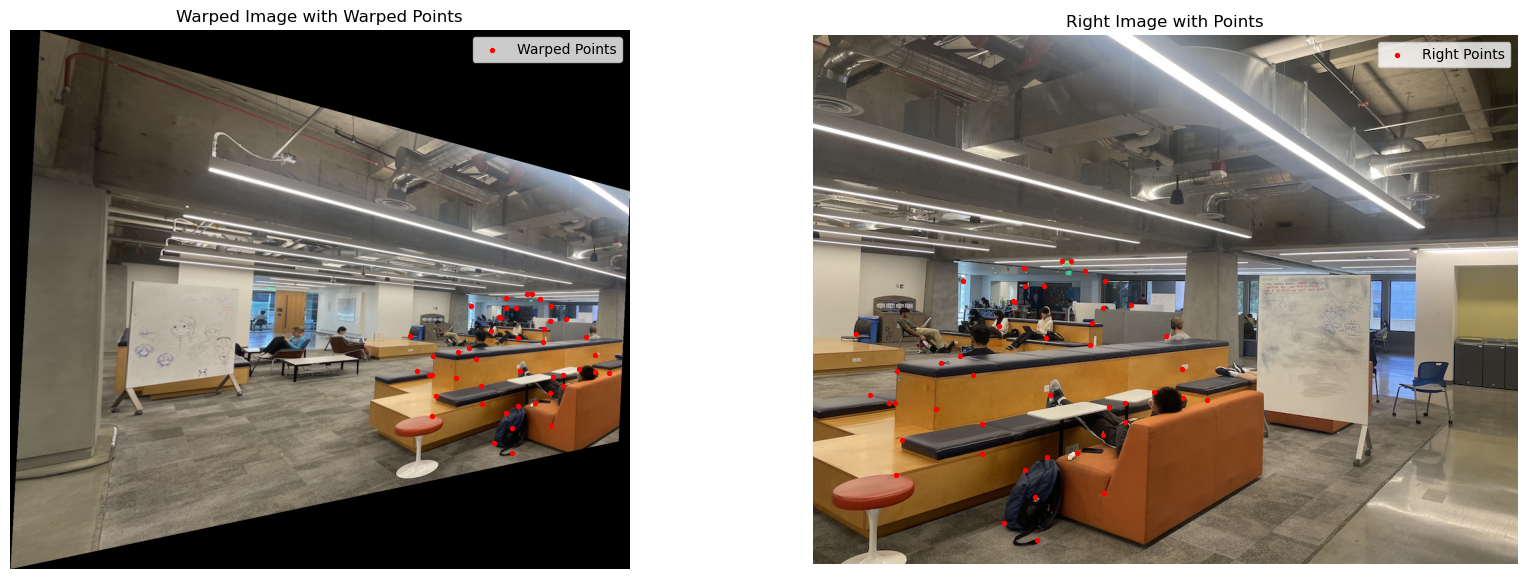

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Display the warped image on the left
ax[0].imshow(image_left_warped, cmap='gray')
ax[0].scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')
ax[0].legend()
ax[0].set_title('Warped Image with Warped Points')
ax[0].axis('off')

# Display the right image on the right
ax[1].imshow(image_right, cmap='gray')
ax[1].scatter(best_im2_pts[:, 0], best_im2_pts[:, 1], c='r', s=8, label='Right Points')
ax[1].legend()
ax[1].set_title('Right Image with Points')
ax[1].axis('off')

plt.show()

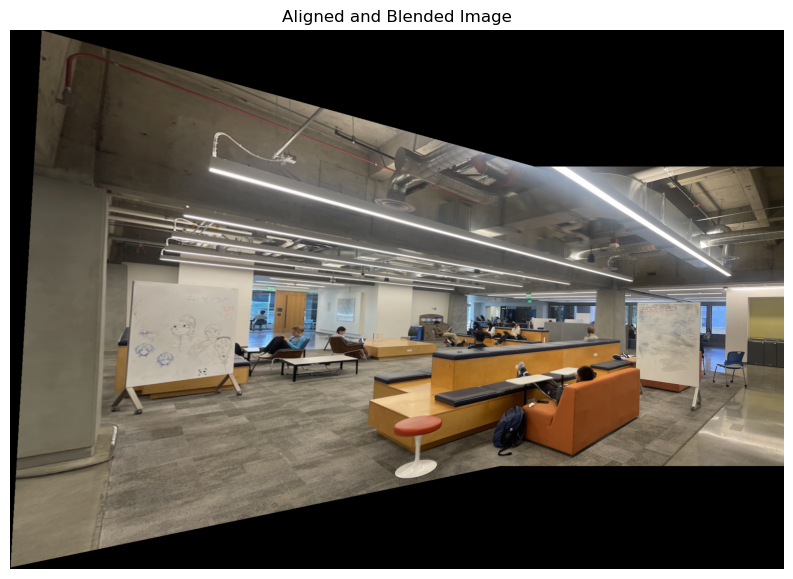

In [23]:
# Align and blend the images
automatic_pts_result_img = align_and_blend_images(image_left_warped, image_right, warped_points, best_im2_pts)

# Display the result
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(automatic_pts_result_img)
ax.set_title('Aligned and Blended Image')
ax.axis('off')

plt.show()

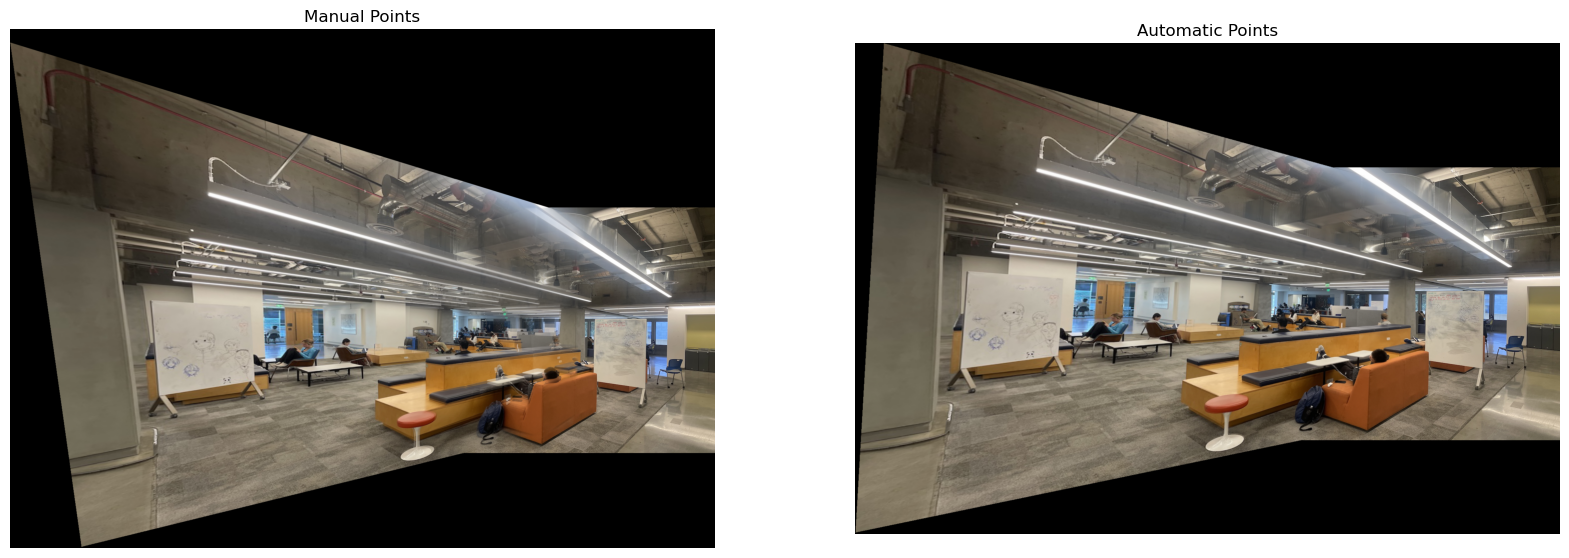

In [24]:
# Distaply the resulting images next to each other
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Display the left image
ax[0].imshow(manual_pts_result_img)
ax[0].set_title('Manual Points')
ax[0].axis('off')

# Display the right image
ax[1].imshow(automatic_pts_result_img, cmap='gray')
ax[1].set_title('Automatic Points')
ax[1].axis('off')

plt.show()